In [1]:
"""Library"""
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from common import (data_path, date_col, missing_code, price_col, projectpath,
                    symbol_col, train_percent, valid_percent)
from sklearn.linear_model import LinearRegression

/home/ling/miniconda3/envs/ap_tf2/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/ling/miniconda3/envs/ap_tf2/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
select = "factor"
with_macro = False

"""Load data"""
data = pd.read_csv(data_path[select])
data[date_col] = pd.to_datetime(data[date_col])
data = data.set_index([symbol_col, date_col])\
    .replace(missing_code, float("NaN"))\
    .dropna(axis=0)\
    .astype("float")

data.head()

excess_returns       hml     r12_7      r2_1        rf  \
symbol date                                                                 
3IN    2008-04-30        0.071916  0.009833 -0.054559  0.040225  0.003991   
       2008-05-31        0.022298 -0.029344 -0.056313  0.071916  0.004108   
       2008-06-30       -0.010799 -0.027738 -0.021389  0.022298  0.004159   
       2008-07-31        0.002396 -0.069655  0.077308 -0.010799  0.004134   
       2008-08-31       -0.072512 -0.001523  0.185581  0.002396  0.004025   

                         rm      rmrf       smb       umd  
symbol date                                                
3IN    2008-04-30  0.062580  0.058589 -0.049409  0.068718  
       2008-05-31 -0.001998 -0.006106 -0.010052  0.044772  
       2008-06-30 -0.070678 -0.074837 -0.024877  0.135133  
       2008-07-31 -0.036035 -0.040168  0.016760  0.001473  
       2008-08-31  0.049905  0.045881 -0.006549 -0.095469

In [3]:
sdf = pd.read_csv(
    f"{projectpath}/data/results/sdf_uk_{select}_macro_{with_macro}.csv"
)
sdf["date"] = pd.to_datetime(sdf["date"])
sdf = sdf.set_index("date")

sdf.head()

,sdf
date,
1998-03-31,0.581224
1998-04-30,-0.198753
1998-05-31,-0.036840
1998-06-30,0.133038
1998-07-31,-0.101732


In [4]:
data = data.combine_first(sdf)

data.head()

excess_returns       hml     r12_7      r2_1        rf  \
symbol date                                                                 
3IN    2008-04-30        0.071916  0.009833 -0.054559  0.040225  0.003991   
       2008-05-31        0.022298 -0.029344 -0.056313  0.071916  0.004108   
       2008-06-30       -0.010799 -0.027738 -0.021389  0.022298  0.004159   
       2008-07-31        0.002396 -0.069655  0.077308 -0.010799  0.004134   
       2008-08-31       -0.072512 -0.001523  0.185581  0.002396  0.004025   

                         rm      rmrf       sdf       smb       umd  
symbol date                                                          
3IN    2008-04-30  0.062580  0.058589  0.163882 -0.049409  0.068718  
       2008-05-31 -0.001998 -0.006106 -0.449918 -0.010052  0.044772  
       2008-06-30 -0.070678 -0.074837  0.088869 -0.024877  0.135133  
       2008-07-31 -0.036035 -0.040168 -0.333298  0.016760  0.001473  
       2008-08-31  0.049905  0.045881  0.282491 -0.006549 -0.095469

In [5]:
"""One asset"""
subset_data = data.loc["ABC", [price_col, "sdf"]]
train_index = round(subset_data.shape[0] * train_percent)
valid_index = round(subset_data.shape[0] * valid_percent)
train_data = subset_data.iloc[:train_index, :]
valid_data = subset_data.iloc[train_index:valid_index, :]
test_data = subset_data.iloc[valid_index:, :]
mod = sm.OLS(train_data.loc[:, price_col],
             train_data.drop(columns=[price_col]).assign(const=1),
             missing=missing_code,
             hasconst=True)

res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         excess_returns   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.125
Date:                Wed, 23 Mar 2022   Prob (F-statistic):              0.292
Time:                        22:03:14   Log-Likelihood:                 55.583
No. Observations:                  90   AIC:                            -107.2
Df Residuals:                      88   BIC:                            -102.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
sdf            0.0421      0.040      1.061      0.292      -0.037       0.121
const          0.0478      0.016      3.059      0.003       0.017       0.079
==============================================================================
Omnibus:                       67.701   Durbin-Watson:                   0.889
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              317.521
Skew:                           2.527   Prob(JB):                     1.13e-69
Kurtosis:                      10.689   Cond. No.                         2.96
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
"""Sklearn Linear Regression"""
coef = {}

for symbol in data.index.get_level_values("symbol").unique():
    subset_data = data.loc[symbol, [price_col, "sdf"]]

    train_index = round(subset_data.shape[0] * train_percent)
    valid_index = round(subset_data.shape[0] * valid_percent)
    train_data = subset_data.iloc[:train_index, :]
    valid_data = subset_data.iloc[train_index:valid_index, :]
    test_data = subset_data.iloc[valid_index:, :]

    train_X = train_data.drop(columns=[price_col])
    train_y = train_data.loc[:, price_col]
    valid_X = valid_data.drop(columns=[price_col])
    valid_y = valid_data.loc[:, price_col]
    test_X = test_data.drop(columns=[price_col])
    test_y = test_data.loc[:, price_col]

    lr = LinearRegression()\
        .fit(train_X, train_y)

    valid_pred = lr.predict(valid_X)
    valid_intercept = (valid_y - valid_pred).mean()

    test_pred = lr.predict(test_X)
    test_intercept = (test_y - test_pred).mean()

    coef[symbol] = dict(zip(lr.feature_names_in_, lr.coef_))
    coef[symbol]["train_intercept"] = lr.intercept_
    coef[symbol]["valid_intercept"] = valid_intercept
    coef[symbol]["test_intercept"] = test_intercept

In [7]:
coef = pd.DataFrame(coef).T

coef

,sdf,train_intercept,valid_intercept,test_intercept
3IN,0.062133,0.025705,-0.032593,-0.031954
888,0.061685,0.024881,-0.038360,-0.017612
88E,0.005430,-0.060825,0.132153,-0.029443
AAIF,0.037364,0.031108,-0.049472,-0.025525
AAL,0.008748,0.029753,-0.040311,-0.029946
...,...,...,...,...
ZIOC,0.024485,-0.088178,0.151793,0.135961
ZOL,0.029492,0.019330,-0.095337,-0.023729
ZOO,-0.017428,0.001285,-0.037162,0.055895
ZTF,0.045230,0.010612,-0.001068,-0.002932


In [8]:
coef["train_intercept"].abs().describe()

count    844.000000
mean       0.028091
std        0.028653
min        0.000013
25%        0.013729
50%        0.022036
75%        0.034145
max        0.331728
Name: train_intercept, dtype: float64

In [9]:
coef["valid_intercept"].abs().describe()

count    844.000000
mean       0.037093
std        0.040244
min        0.000012
25%        0.009933
50%        0.023126
75%        0.049874
max        0.297467
Name: valid_intercept, dtype: float64

In [10]:
coef["test_intercept"].abs().describe()

count    844.000000
mean       0.046532
std        0.050407
min        0.000030
25%        0.016278
50%        0.029079
75%        0.054881
max        0.319812
Name: test_intercept, dtype: float64

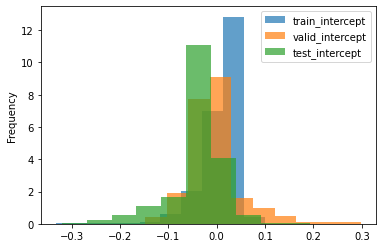

In [11]:
coef["train_intercept"].plot.hist(density=True, alpha=0.7)
coef["valid_intercept"].plot.hist(density=True, alpha=0.7)
coef["test_intercept"].plot.hist(density=True, alpha=0.7)
plt.legend()

In [12]:
# export results
coef.to_csv(f"{projectpath}/data/alpha/gan_{select}_macro_{with_macro}.csv")